# Import Libraries

In [1]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt


# Load model

In [2]:
from tensorflow.keras.models import load_model

# Load the entire model
model = load_model('lung_cancer_model.h5')

# Image Loading and Preprocessing

In [3]:
# Function to load and preprocess the main image
def load_and_preprocess_image(img_path, target_size=(256, 256)):
    """
    Load an image, resize it, convert to tensor, and normalize to [0, 1].
    
    Args:
        img_path (str): Path to the image file.
        target_size (tuple): Target size to resize the image (default: (256, 256)).
    
    Returns:
        tf.Tensor: Preprocessed image tensor of shape (1, height, width, channels).
    """
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0) / 255.0
    return tf.convert_to_tensor(img_batch, dtype=tf.float32)


# Generate Baseline

In [4]:
# Function to generate a baseline image
def generate_baseline(image, baseline_type="zeros"):
    """
    Generate a baseline image for Integrated Gradients computation.
    
    Args:
        image (tf.Tensor): Input image tensor.
        baseline_type (str): Type of baseline ('zeros', 'random', 'mean').
    
    Returns:
        tf.Tensor: Baseline image tensor with the same shape as the input.
    """
    if baseline_type == "zeros":
        return tf.zeros_like(image)
    elif baseline_type == "random":
        return tf.random.uniform(shape=image.shape, minval=0, maxval=1)
    elif baseline_type == "mean":
        return tf.ones_like(image) * tf.reduce_mean(image)
    else:
        raise ValueError(f"Invalid baseline_type: {baseline_type}")


# Interpolation

In [5]:
# Function to interpolate between baseline and input image
def interpolate_images(baseline, image, steps=50):
    """
    Generate interpolated images between the baseline and input image.
    
    Args:
        baseline (tf.Tensor): Baseline image tensor.
        image (tf.Tensor): Input image tensor.
        steps (int): Number of interpolation steps.
    
    Returns:
        tf.Tensor: Interpolated image tensors of shape (steps, height, width, channels).
    """
    alphas = tf.linspace(0.0, 1.0, steps)[:, tf.newaxis, tf.newaxis, tf.newaxis]
    return baseline + alphas * (image - baseline)


# Compute Gradient

In [6]:
# Function to compute gradients
@tf.function
def compute_gradients(images, model, target_class_idx):
    """
    Compute gradients of predictions with respect to input images.
    
    Args:
        images (tf.Tensor): Batch of input images.
        model (tf.keras.Model): Pre-trained model.
        target_class_idx (int): Index of the target class.
    
    Returns:
        tf.Tensor: Gradients with the same shape as input images.
    """
    with tf.GradientTape() as tape:
        tape.watch(images)
        predictions = model(images)
        target_predictions = predictions[:, target_class_idx]
    return tape.gradient(target_predictions, images)


# Integrated Gradients

In [7]:
# Function to compute Integrated Gradients
def integrated_gradients(baseline, image, model, target_class_idx, steps=50):
    """
    Compute Integrated Gradients for a given model and input image.
    
    Args:
        baseline (tf.Tensor): Baseline image tensor.
        image (tf.Tensor): Input image tensor.
        model (tf.keras.Model): Pre-trained model.
        target_class_idx (int): Index of the target class.
        steps (int): Number of interpolation steps.
    
    Returns:
        tf.Tensor: Attributions with the same shape as the input image.
    """
    interpolated_images = interpolate_images(baseline, image, steps)
    gradients = compute_gradients(interpolated_images, model, target_class_idx)
    avg_gradients = tf.reduce_mean(gradients, axis=0)
    return (image - baseline) * avg_gradients


# Visualization

In [8]:
# Function to visualize attributions
def visualize_attributions(image, attributions):
    """
    Visualize the original image, attribution heatmap, and overlay.
    
    Args:
        image (tf.Tensor): Original image tensor.
        attributions (tf.Tensor): Attribution values for each pixel.
    """
    plt.figure(figsize=(12, 5))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title("Original Image")
    
    # Attribution heatmap
    plt.subplot(1, 3, 2)
    plt.imshow(tf.reduce_sum(attributions, axis=-1), cmap="RdBu")
    plt.axis("off")
    plt.title("Attribution Heatmap")
    
    # Overlay of heatmap on original image
    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.imshow(tf.reduce_sum(attributions, axis=-1), cmap="RdBu", alpha=0.5)
    plt.axis("off")
    plt.title("Overlay")
    plt.show()


# Workflow

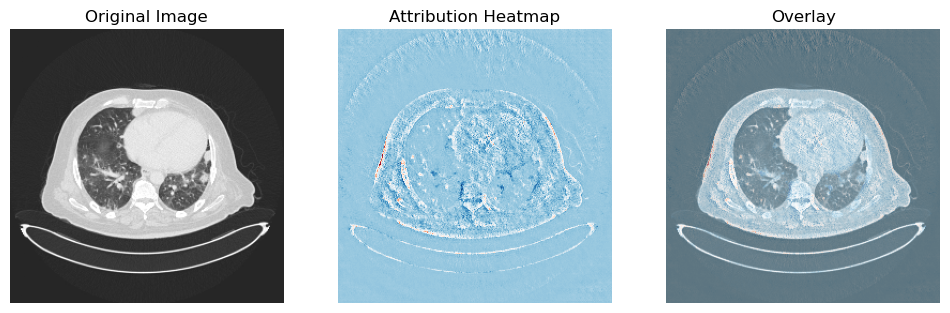

In [9]:
# Example workflow for using Integrated Gradients
if __name__ == "__main__":
    # Define constants
    IMG_PATH = 'lung_cancer_dataset/Malignant cases/Malignant case (108).jpg'  # Replace with your image path
    STEPS = 50
    TARGET_CLASS_IDX = 1  # Replace with your target class index
    BASELINE_TYPE = "zeros"  # Baseline type: 'zeros', 'random', or 'mean'
    
    # Load and preprocess the input image
    image_tensor = load_and_preprocess_image(IMG_PATH)
    baseline = generate_baseline(image_tensor, baseline_type=BASELINE_TYPE)
    
    # Remove batch dimension for IG computation
    image_tensor = tf.squeeze(image_tensor, axis=0)  # Shape: (256, 256, 3)
    baseline = tf.squeeze(baseline, axis=0)  # Shape: (256, 256, 3)
    
    # Load the model (replace with your actual model)
    # model = tf.keras.models.load_model('path/to/your/model.h5')  # Uncomment this line
    
    # Compute Integrated Gradients
    integrated_grads = integrated_gradients(baseline, image_tensor, model, TARGET_CLASS_IDX, steps=STEPS)
    
    # Visualize the attributions
    visualize_attributions(image_tensor.numpy(), integrated_grads.numpy())


# Visualization with thresholding

In [10]:
def visualize_attributions_with_threshold(image, attributions, threshold=0.5):
    """
    Visualize the original image, attribution heatmap with thresholding, and overlay.
    
    Args:
        image (tf.Tensor): Original image tensor.
        attributions (tf.Tensor): Attribution values for each pixel.
        threshold (float): Threshold for highlighting high-attribution regions.
    """
    # Normalize attributions for visualization (min-max scaling)
    attributions = tf.reduce_sum(attributions, axis=-1)  # Reduce across color channels
    attributions = (attributions - tf.reduce_min(attributions)) / (tf.reduce_max(attributions) - tf.reduce_min(attributions))
    
    # Apply threshold
    highlighted_attributions = tf.where(attributions >= threshold, attributions, 0)
    
    plt.figure(figsize=(12, 5))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title("Original Image")
    
    # Attribution heatmap with thresholding
    plt.subplot(1, 3, 2)
    plt.imshow(highlighted_attributions, cmap="RdBu")  # 'hot' colormap for emphasis
    plt.axis("off")
    plt.title(f"Thresholded Heatmap (Threshold={threshold})")
    
    # Overlay of thresholded heatmap on original image
    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.imshow(highlighted_attributions, cmap="RdBu", alpha=0.5)  # Semi-transparent overlay
    plt.axis("off")
    plt.title("Overlay with Thresholding")
    
    plt.show()


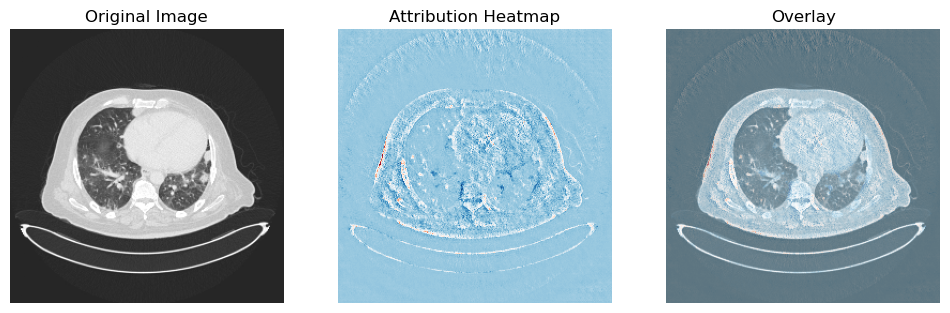

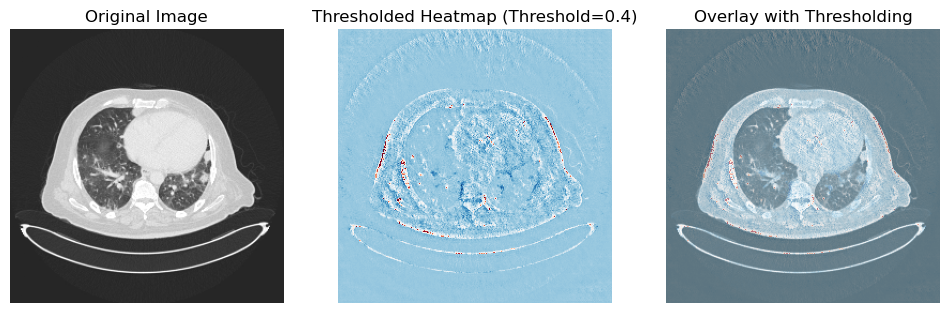

In [11]:
# Example workflow for using Integrated Gradients
if __name__ == "__main__":
    # Define constants
    IMG_PATH = 'lung_cancer_dataset/Malignant cases/Malignant case (108).jpg'  # Replace with your image path
    STEPS = 50
    TARGET_CLASS_IDX = 1  # Replace with your target class index
    BASELINE_TYPE = "zeros"  # Baseline type: 'zeros', 'random', or 'mean'
    
    # Load and preprocess the input image
    image_tensor = load_and_preprocess_image(IMG_PATH)
    baseline = generate_baseline(image_tensor, baseline_type=BASELINE_TYPE)
    
    # Remove batch dimension for IG computation
    image_tensor = tf.squeeze(image_tensor, axis=0)  # Shape: (256, 256, 3)
    baseline = tf.squeeze(baseline, axis=0)  # Shape: (256, 256, 3)
    
    # Load the model (replace with your actual model)
    # model = tf.keras.models.load_model('path/to/your/model.h5')  # Uncomment this line
    
    # Compute Integrated Gradients
    integrated_grads = integrated_gradients(baseline, image_tensor, model, TARGET_CLASS_IDX, steps=STEPS)
    
    # Visualize the attributions
    visualize_attributions(image_tensor.numpy(), integrated_grads.numpy())

# Call the updated visualization function
    THRESHOLD = 0.4 # Adjust as needed
    visualize_attributions_with_threshold(image_tensor.numpy(), integrated_grads.numpy(), threshold=THRESHOLD)
